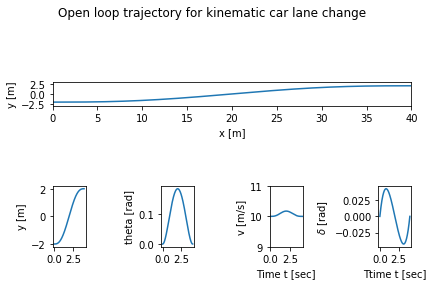

In [1]:
# kincar-flatsys.py - differentially flat systems example
# RMM, 3 Jul 2019
#
# This example demonstrates the use of the `flatsys` module for generating
# trajectories for differnetially flat systems by computing a trajectory for a
# kinematic (bicycle) model of a car changing lanes.

import os
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import control.flatsys as fs


# Function to take states, inputs and return the flat flag
def vehicle_flat_forward(x, u, params={}):
    # Get the parameter values
    b = params.get('wheelbase', 3.)

    # Create a list of arrays to store the flat output and its derivatives
    zflag = [np.zeros(3), np.zeros(3)]

    # Flat output is the x, y position of the rear wheels
    zflag[0][0] = x[0]
    zflag[1][0] = x[1]

    # First derivatives of the flat output
    zflag[0][1] = u[0] * np.cos(x[2])  # dx/dt
    zflag[1][1] = u[0] * np.sin(x[2])  # dy/dt

    # First derivative of the angle
    thdot = (u[0]/b) * np.tan(u[1])

    # Second derivatives of the flat output (setting vdot = 0)
    zflag[0][2] = -u[0] * thdot * np.sin(x[2])
    zflag[1][2] =  u[0] * thdot * np.cos(x[2])

    return zflag


# Function to take the flat flag and return states, inputs
def vehicle_flat_reverse(zflag, params={}):
    # Get the parameter values
    b = params.get('wheelbase', 3.)

    # Create a vector to store the state and inputs
    x = np.zeros(3)
    u = np.zeros(2)

    # Given the flat variables, solve for the state
    x[0] = zflag[0][0]  # x position
    x[1] = zflag[1][0]  # y position
    x[2] = np.arctan2(zflag[1][1], zflag[0][1])  # tan(theta) = ydot/xdot

    # And next solve for the inputs
    u[0] = zflag[0][1] * np.cos(x[2]) + zflag[1][1] * np.sin(x[2])
    thdot_v = zflag[1][2] * np.cos(x[2]) - zflag[0][2] * np.sin(x[2])
    u[1] = np.arctan2(thdot_v, u[0]**2 / b)

    return x, u


# Function to compute the RHS of the system dynamics
def vehicle_update(t, x, u, params):
    b = params.get('wheelbase', 3.)             # get parameter values
    dx = np.array([
        np.cos(x[2]) * u[0],
        np.sin(x[2]) * u[0],
        (u[0]/b) * np.tan(u[1])
    ])
    return dx


# Create differentially flat input/output system
vehicle_flat = fs.FlatSystem(
    vehicle_flat_forward, vehicle_flat_reverse, vehicle_update,
    inputs=('v', 'delta'), outputs=('x', 'y', 'theta'),
    states=('x', 'y', 'theta'))

# Define the endpoints of the trajectory
x0 = [0., -2., 0.]; u0 = [10., 0.]
xf = [40., 2., 0.]; uf = [10., 0.]
Tf = 4

# Define a set of basis functions to use for the trajectories
poly = fs.PolyFamily(6)

# Find a trajectory between the initial condition and the final condition
traj = fs.point_to_point(vehicle_flat, x0, u0, xf, uf, Tf, basis=poly)

# Create the desired trajectory between the initial and final condition
T = np.linspace(0, Tf, 500)
xd, ud = traj.eval(T)

# Simulation the open system dynamics with the full input
t, y, x = ct.input_output_response(
    vehicle_flat, T, ud, x0, return_x=True)

# Plot the open loop system dynamics
plt.figure()
plt.suptitle("Open loop trajectory for kinematic car lane change")

# Plot the trajectory in xy coordinates
plt.subplot(4, 1, 2)
plt.plot(x[0], x[1])
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis([x0[0], xf[0], x0[1]-1, xf[1]+1])

# Time traces of the state and input
plt.subplot(2, 4, 5)
plt.plot(t, x[1])
plt.ylabel('y [m]')

plt.subplot(2, 4, 6)
plt.plot(t, x[2])
plt.ylabel('theta [rad]')

plt.subplot(2, 4, 7)
plt.plot(t, ud[0])
plt.xlabel('Time t [sec]')
plt.ylabel('v [m/s]')
plt.axis([0, Tf, u0[0] - 1, uf[0] + 1])

plt.subplot(2, 4, 8)
plt.plot(t, ud[1])
plt.xlabel('Ttime t [sec]')
plt.ylabel('$\delta$ [rad]')
plt.tight_layout()

# Show the results unless we are running in batch mode
if 'PYCONTROL_TEST_EXAMPLES' not in os.environ:
    plt.show()